In [1640]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

from basic_utils import *
import numpy as np

pd.set_option('display.max_rows', 20)

In [2070]:
def fromts_todate(df, column):
    return [date.fromtimestamp(x) for x in df[column].values]

def if_col_value(df, col_name):
    return df[col_name] if (df.columns.contains(col_name)) else 0

def fs_total_subset(df, columns):
    """Sums a subset of columns"""
    fin_section = df[columns]
    return fin_section.sum(axis=1).sort_index(ascending=True)

def fs_append_ltm(last4A, last4Q):
    """Calculates LTM (sum of last four quarters) and returns appended DataFrame"""
    last4Q.sort_index(ascending=True, inplace=True)
    last4A.sort_index(ascending=True, inplace=True)
    if last4A.index[-1] != last4Q.index[-1]:
        last4A.loc[last4Q.index[-1]] = last4Q.sum()
    return last4A.sort_index()

def fs_available_labels(df, labels):
    """Returns the labels contained in the DataFrame"""
    return [x for x in labels if df.columns.contains(x)]

def convert_dates(df, dateCols, sortCol):
    for x in dateCols:
        df[x] = fromts_todate(df, x)
    df = df.sort_values(sortCol)
    df = df.set_index(sortCol, drop=True)
    return df

def fs_append_ltm(dfA, dfQ, isBs, exclCols):
    """Calculates LTM (sum of last four quarters) and returns appended DataFrame"""
    if dfQ.index[-1] > dfA.index[-1]:
        dfA.loc[dfQ.index[-1]] = dfQ.loc[dfQ.index[-1]]
        if not isBs:
            sum_cols = [x for x in dfQ.columns.tolist() if x not in excl_cols]
            sum_cols = [x for x in dfQ.columns.tolist() if x not in excl_cols]
            dfA.loc[dfQ.index[-1], sum_cols] = dfQ[sum_cols].sum()
    return dfA.sort_index()

def list_cols_excl(allCols, exclCols):
    return [x for x in allCols if x not in exclCols]

In [2068]:
date_cols = ['endDate', 'storeDate']
excl_cols = ['maxAge', 'symbol', 'period', 'storeDate']
dates = read_dates('quote') 

In [1643]:
UNIT_SCALE = 10**9
tgt_date = ['2019-02-01'] # hardcoded for now
tgt_date

['2019-02-01']

### Load data from S3

In [1958]:
latest_quotes = load_csvs('quote_consol', tgt_date)
profile = load_csvs('summary_detail', ['assetProfile'])
latest_keystats = load_csvs('summary_detail', ['defaultKeyStatistics/' + str(tgt_date[0])])
latest_finstats = load_csvs('summary_detail', ['financialData/' + str(tgt_date[0])])

Loading file quote/csv/2019-02-01
Loading file summary-categories/assetProfile
Loading file summary-categories/defaultKeyStatistics/2019-02-01
Loading file summary-categories/financialData/2019-02-01


In [1959]:
latest_finBS = load_csvs('summary_detail', ['financials-BS'])
latest_finIS = load_csvs('summary_detail', ['financials-IS'])
latest_finCF = load_csvs('summary_detail', ['financials-CF'])

Loading file summary-categories/financials-BS
Loading file summary-categories/financials-IS
Loading file summary-categories/financials-CF


### Select company

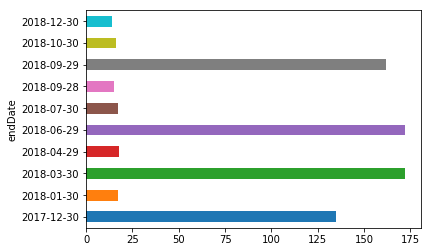

In [2071]:
# Show how many companies have updates financials
field = 'cash'
fil_period = latest_finBS[(latest_finBS.period == 'Q')]
date_count_df = fil_period[['symbol','endDate', field]]\
    .groupby('endDate').count()\
    .sort_values(by=field, ascending=False).head(10)
date_count_df['endDate'] = fromts_todate(
    date_count_df.reset_index(), 'endDate')
date_count_df.set_index('endDate').sort_index(ascending=True)[field].plot.barh()

In [1942]:
latest_finBS.symbol.unique()

array(['A', 'AAPL', 'ADBE', 'ADP', 'ADSK', 'AEIS', 'AEO', 'AKAM', 'ALGN',
       'ALRM', 'AMAT', 'AMD', 'AME', 'AMZN', 'ANET', 'ANSS', 'ANTM',
       'APPF', 'APTV', 'AQB', 'ARCT', 'ARNC', 'ATGE', 'ATHN', 'ATTU',
       'ATVI', 'AVAV', 'AVX', 'AYX', 'BABA', 'BBY', 'BC', 'BGNE', 'BIDU',
       'BIIB', 'BKNG', 'BL', 'BLCM', 'BLUE', 'BMY', 'BOX', 'BRKR', 'BRKS',
       'CAMT', 'CBM', 'CCMP', 'CDNS', 'CELG', 'CERN', 'CERS', 'CGEN',
       'CGNX', 'CHGG', 'CHKP', 'CI', 'CLLS', 'CNC', 'COLM', 'COUP',
       'CREE', 'CRM', 'CRNT', 'CRSP', 'CRUS', 'CSCO', 'CSOD', 'CTSH',
       'CVLT', 'CYBR', 'DATA', 'DBX', 'DDD', 'DECK', 'DLB', 'DMLRY',
       'DORM', 'DOX', 'DSW', 'DXCM', 'EA', 'EBS', 'EDIT', 'EDU', 'EEFT',
       'ELLI', 'EPAM', 'ESLT', 'ETSY', 'EVGN', 'EVLO', 'EW', 'EXEL',
       'EXLS', 'EXPE', 'F', 'FARO', 'FB', 'FFIV', 'FIVE', 'FIVN', 'FL',
       'FLIR', 'FOMX', 'FTNT', 'GHC', 'GILD', 'GILT', 'GLMD', 'GM',
       'GMED', 'GNTX', 'GOOG', 'GPS', 'GRUB', 'GSKY', 'GWRE', 'HALO',
       'H

In [2072]:
symbol = 'EA'
ks_df = latest_keystats[latest_keystats.symbol == symbol]
ks_df.sharesOutstanding

79    302128992
Name: sharesOutstanding, dtype: int64

In [2073]:
# Show basic structure of the loaded dataframe
# profile.info()
# latest_quotes.info()
# latest_keystats.info()
# latest_finstats.info()
# latest_finBS.info()
# latest_finIS.info()
# latest_finCF.info()

### Perform analysis

In [2074]:
# Balance sheet calculations
df = latest_finBS.copy()
df = convert_dates(df, date_cols, 'endDate')
mask_perQ = (df.period == 'Q')
mask_perA = (df.period == 'A')

mask_symbol = (df.symbol == symbol) 
df = df[mask_symbol]
print("Balance Sheet labels:\n", df.T.index)

# Balance Sheet
wc_assets = ['netReceivables', 'inventory']
wc_liabs = ['accountsPayable']
total_cash = ['cash', 'shortTermInvestments', 'longTermInvestments']
total_debt = ['shortLongTermDebt', 'longTermDebt']
bs_summary = ['totalAssets', 'workingCapital', 'adjAssetBase','totalCash', 
              'adjAssetBaseLessCash', 'netDebt']

dfA = df[(df.period == 'A')]
dfQ = df[(df.period == 'Q')]
dfA = fs_append_ltm(dfA, dfQ, True, excl_cols)
dfA.loc[:, 'workingCapital'] = fs_total_subset(dfA, wc_assets) - fs_total_subset(dfA, wc_liabs)
dfA.loc[:, 'adjAssetBase'] = dfA['totalAssets'] + dfA['workingCapital'].apply(min, args=(0,))
dfA.loc[:, 'totalCash'] = fs_total_subset(dfA, total_cash)
dfA.loc[:, 'totalDebt'] = fs_total_subset(dfA, total_debt)
dfA.loc[:, 'netDebt'] = dfA['totalDebt'] - dfA['totalCash']
dfA.loc[:, 'adjAssetBaseLessCash'] = dfA['adjAssetBase'] + dfA['netDebt'].apply(min, args=(0,))
bs_sum = dfA[bs_summary].copy()
(bs_sum / UNIT_SCALE).T.round(1)

Balance Sheet labels:
 Index(['maxAge', 'cash', 'netReceivables', 'inventory', 'otherCurrentAssets',
       'totalCurrentAssets', 'longTermInvestments', 'propertyPlantEquipment',
       'goodWill', 'intangibleAssets', 'otherAssets',
       'deferredLongTermAssetCharges', 'totalAssets', 'accountsPayable',
       'otherCurrentLiab', 'longTermDebt', 'otherLiab', 'minorityInterest',
       'totalCurrentLiabilities', 'totalLiab', 'commonStock',
       'retainedEarnings', 'treasuryStock', 'capitalSurplus',
       'otherStockholderEquity', 'totalStockholderEquity', 'netTangibleAssets',
       'symbol', 'period', 'shortTermInvestments', 'shortLongTermDebt',
       'deferredLongTermLiab', 'storeDate'],
      dtype='object')


/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


endDate,2015-03-30,2016-03-30,2017-03-30,2018-03-30,2018-09-29
totalAssets,6.1,7.0,7.7,8.6,8.4
workingCapital,0.3,0.1,0.3,0.3,0.8
adjAssetBase,6.1,7.0,7.7,8.6,8.4
totalCash,3.0,3.8,4.5,5.3,4.5
adjAssetBaseLessCash,3.7,3.4,3.2,3.3,4.9
netDebt,-2.4,-3.7,-4.5,-5.3,-3.6


In [2075]:
# Cash flow items
df = latest_finCF.copy()
df = convert_dates(df, date_cols, 'endDate')
mask_symbol = (df.symbol == symbol) 
df = df[mask_symbol]

print("Cash Flow Statement labels:\n", df.T.index)

cf_summary = ['totalCashFromOperatingActivities', 'depreciation', 
              'steadyCF', 'capitalExpenditures', 
              'netBorrowings', 'steadyFCF', 'growthCapex', 
              'repurchaseOfStock', 'dividendsPaid', 'sbcAddbacks']

dfA = df[(df.period == 'A')]
dfQ = df[(df.period == 'Q')]
dfA = fs_append_ltm(dfA, dfQ, False, excl_cols)
dfA.loc[:, 'steadyCF'] = dfA.totalCashFromOperatingActivities - dfA['depreciation']
dfA.loc[:, 'steadyFCF'] = dfA['steadyCF'] + dfA['netBorrowings'].apply(min, args=(0,))
dfA.loc[:, 'growthCapex'] = np.abs(dfA.capitalExpenditures) - dfA.depreciation
dfA.loc[:, 'sbcAddbacks'] = fs_total_subset(
    dfA, ['changeToNetincome', 'changeToOperatingActivities'])
cf_sum = dfA[cf_summary].copy()
(cf_sum / UNIT_SCALE).T.round(1)

Cash Flow Statement labels:
 Index(['maxAge', 'netIncome', 'depreciation', 'changeToNetincome',
       'changeToAccountReceivables', 'changeToLiabilities',
       'changeToInventory', 'changeToOperatingActivities',
       'totalCashFromOperatingActivities', 'capitalExpenditures',
       'investments', 'otherCashflowsFromInvestingActivities',
       'totalCashflowsFromInvestingActivities', 'dividendsPaid',
       'netBorrowings', 'otherCashflowsFromFinancingActivities',
       'totalCashFromFinancingActivities', 'effectOfExchangeRate',
       'changeInCash', 'repurchaseOfStock', 'issuanceOfStock', 'symbol',
       'period', 'storeDate'],
      dtype='object')


/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


endDate,2015-03-30,2016-03-30,2017-03-30,2018-03-30,2018-09-29
totalCashFromOperatingActivities,1.1,1.5,1.6,1.7,1.5
depreciation,0.2,0.2,0.2,0.1,0.1
steadyCF,0.9,1.3,1.4,1.6,1.3
capitalExpenditures,-0.1,-0.1,-0.1,-0.1,-0.1
netBorrowings,0.5,0.5,-0.2,NaN,0.0
steadyFCF,0.9,1.3,1.2,NaN,1.3
growthCapex,-0.1,-0.1,-0.0,-0.0,-0.0
repurchaseOfStock,-0.3,-1.2,-0.6,-0.7,-1.0
dividendsPaid,NaN,NaN,NaN,NaN,0.0
sbcAddbacks,0.3,0.2,0.4,0.3,0.2


In [2076]:
# plt_lineitems = ['steadyCF', 'steadyFCF', 'growthCapex']
# (cf_sum[plt_lineitems] / UNIT_SCALE).plot.bar()

In [2077]:
# num_cols = list_cols_excl(dfA.columns, excl_cols)
(dfA[num_cols].T / UNIT_SCALE).round(1)

endDate,2015-03-30,2016-03-30,2017-03-30,2018-03-30,2018-09-29
netIncome,0.9,1.2,1.0,1.0,1.0
depreciation,0.2,0.2,0.2,0.1,0.1
changeToNetincome,0.1,0.2,0.2,0.2,0.3
changeToAccountReceivables,-0.1,0.1,-0.1,-0.0,0.0
changeToLiabilities,-0.3,-0.2,0.2,0.2,0.2
changeToInventory,NaN,NaN,NaN,NaN,0.0
changeToOperatingActivities,0.1,0.0,0.2,0.1,-0.1
totalCashFromOperatingActivities,1.1,1.5,1.6,1.7,1.5
capitalExpenditures,-0.1,-0.1,-0.1,-0.1,-0.1
investments,-0.4,-0.4,-0.6,0.9,0.6


In [2078]:
# Income statement calcs
df = latest_finIS.copy()
df = convert_dates(df, date_cols, 'endDate')
mask_symbol = (df.symbol == symbol) 
df = df[mask_symbol]
print("Income Statement labels:\n", df.T.index)

cash_cost_growth = ['researchDevelopment',
                    'sellingGeneralAdministrative']
is_summary = ['totalRevenue','growthCost']

dfA = df[(df.period == 'A')]
dfQ = df[(df.period == 'Q')]
dfA = fs_append_ltm(dfA, dfQ, False, excl_cols)
cost_gr_df = fs_total_subset(dfA, cash_cost_growth)
dfA.loc[:, 'growthCost'] = (cost_gr_df - cost_gr_df.shift(1)) \
    - cf_sum.sbcAddbacks.apply(min, args=(0,))
is_sum = dfA[is_summary].copy()

(is_sum / UNIT_SCALE).T.round(1)

Income Statement labels:
 Index(['maxAge', 'totalRevenue', 'costOfRevenue', 'grossProfit',
       'researchDevelopment', 'sellingGeneralAdministrative',
       'totalOperatingExpenses', 'operatingIncome',
       'totalOtherIncomeExpenseNet', 'ebit', 'interestExpense',
       'incomeBeforeTax', 'incomeTaxExpense', 'minorityInterest',
       'netIncomeFromContinuingOps', 'discontinuedOperations', 'netIncome',
       'netIncomeApplicableToCommonShares', 'symbol', 'period',
       'otherOperatingExpenses', 'storeDate'],
      dtype='object')


/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


endDate,2015-03-30,2016-03-30,2017-03-30,2018-03-30,2018-09-29
totalRevenue,4.5,4.4,4.8,5.2,5.2
growthCost,NaN,0.0,0.2,0.1,0.1


In [2079]:
# Valuation calculations
key_cols = ['totalAssets','adjAssetBaseLessCash', 'netDebt',
           'totalRevenue', 'steadyCF', 'steadyFCF', 'reinvCapital',
           'ROA', 'ROE', 'AT', 'AAT']

val_df = bs_sum.copy()
val_df[cf_sum.columns] = cf_sum
val_df[is_sum.columns] = is_sum
val_df['avgTotalAssets'] = val_df['totalAssets'].rolling(2).mean() # avg asset base
val_df['avgAssetBaseLC'] = val_df['adjAssetBaseLessCash'].rolling(2).mean() # avg asset base
val_df.avgTotalAssets[0] = val_df.totalAssets[0]
val_df.avgAssetBaseLC[0] = val_df.adjAssetBaseLessCash[0]
val_df['reinvCapital'] = (val_df['growthCapex'] + val_df['growthCost']).apply(max, args=(0,))
val_df['ROA'] = (val_df.steadyCF / val_df.avgTotalAssets)
val_df['ROE'] = (val_df.steadyFCF / val_df.avgAssetBaseLC)
val_df['AT'] = (val_df.totalRevenue / val_df.avgTotalAssets)
val_df['AAT'] = (val_df.totalRevenue / val_df.avgAssetBaseLC)
ROA.mean().round(2), ROE.mean().round(2), AT.mean().round(2), AAT.mean().round(2)
(val_df[key_cols[:-4]] / UNIT_SCALE).T.round(1)

endDate,2015-03-30,2016-03-30,2017-03-30,2018-03-30,2018-09-29
totalAssets,6.1,7.0,7.7,8.6,8.4
adjAssetBaseLessCash,3.7,3.4,3.2,3.3,4.9
netDebt,-2.4,-3.7,-4.5,-5.3,-3.6
totalRevenue,4.5,4.4,4.8,5.2,5.2
steadyCF,0.9,1.3,1.4,1.6,1.3
steadyFCF,0.9,1.3,1.2,NaN,1.3
reinvCapital,NaN,0.0,0.1,0.1,0.0


In [2080]:
years = (val_df.index[-1] -   val_df.index[0]).days / 365
cagr_series = pow(val_df.iloc[-1] / val_df.iloc[0], (1 / years)) - 1
cagr_series['steadyFCF']

0.12365042886280264

In [2081]:
# historical growth rates
# growth_cols = ['totalRevenue','totalAssets', 'totalCashFromOperatingActivities', 'steadyCF', 'steadyFCF', 'capitalExpenditures', 'reinvCapital']
growth_cols = ['steadyFCF']
cagr_series[growth_cols].median()
growth_rate = max(cagr_series[growth_cols].median(), 0)
cagr_series[growth_cols], growth_rate

(steadyFCF    0.12365
 dtype: float64, 0.12365042886280264)

In [2082]:
(val_df[val_df.columns[-4:]]).T.round(2)

endDate,2015-03-30,2016-03-30,2017-03-30,2018-03-30,2018-09-29
ROA,0.14,0.20,0.19,0.19,0.15
ROE,0.23,0.36,0.38,NaN,0.32
AT,0.73,0.67,0.66,0.63,0.61
AAT,1.21,1.24,1.48,1.60,1.27


In [2083]:
ROE = val_df.iloc[-1]['ROE']
val_df.iloc[-1][['ROA', 'ROE','AT', 'AAT']].round(2)

ROA    0.15
ROE    0.32
AT     0.61
AAT    1.27
Name: 2018-09-29, dtype: float64

In [2084]:
discount = 0.028 + 0.05 + 0.005
gr_discount = discount * 1
# models fails to incorporate future growth
# consider discount rate - actual growth * capitalization factor of [0.3] 
growth = growth_rate * 0.3
mult, gr_mult = round(1/discount, 2), mult + growth * 100
mult, gr_mult

(12.05, 15.75951286588408)

In [2085]:
npv_CF = val_df.steadyCF[-1] * mult
npv_GR = (val_df.reinvCapital.sum() * ROE * gr_mult) \
    if val_df.reinvCapital.sum() > 0 else 0
[round(x/UNIT_SCALE,2) for x in [npv_CF, -val_df.netDebt[-1], npv_GR]]

[15.81, 3.55, 1.22]

In [2086]:
equityVal = npv_CF - val_df.netDebt[-1] + npv_GR
equityVal / ks_df.sharesOutstanding

79    68.113975
Name: sharesOutstanding, dtype: float64